In [1]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.cluster import KMeans
from pykalman import KalmanFilter 
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt          
%matplotlib inline
import itertools
from collections import OrderedDict
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import sys
import errno

In [2]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [3]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
#one day in seconds
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']
df['logPrice'] = df['weightedAverage'].apply(np.log)

In [4]:
def fitKCA(t,z,q,fwd=0):
    """
        Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
        Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    """
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
               [0,1,h],
               [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2)Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf = kf.em(z)
    #4) Smooth
    x_mean,x_covar = kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                                          filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1) 
    for i in range(1,x_covar.shape[1]): 
        x_std_=x_covar[:,i,i]**.5 
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1) 
    return x_mean,x_std,x_covar

In [5]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [27]:
def run(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    #x_mean,x_std,x_covar=fitKCA(df.date.values, df.y.values, .1) 
    
    df['velocity'] = result[0][:,1]
    df['acceleration'] = result[0][:,2]
    #df['velocity'] = x_mean[:,1]
    #df['acceleration'] = x_mean[:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)

count    645.000000
mean       0.000108
std        0.004575
min       -0.036567
25%       -0.000969
50%        0.000157
75%        0.001473
max        0.023032
Name: velocity, dtype: float64
count    6.450000e+02
mean    -8.059161e-11
std      5.992122e-08
min     -3.685753e-07
25%     -1.541691e-08
50%      8.340199e-10
75%      1.807197e-08
max      3.913671e-07
Name: acceleration, dtype: float64


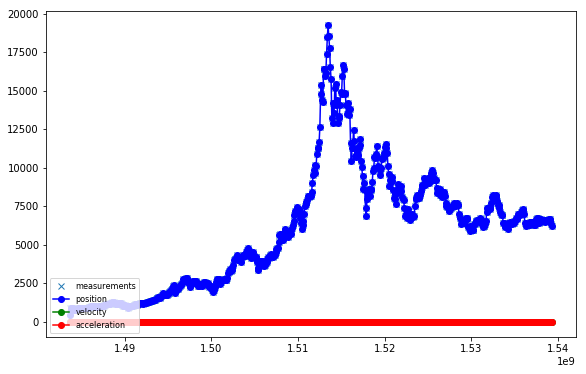

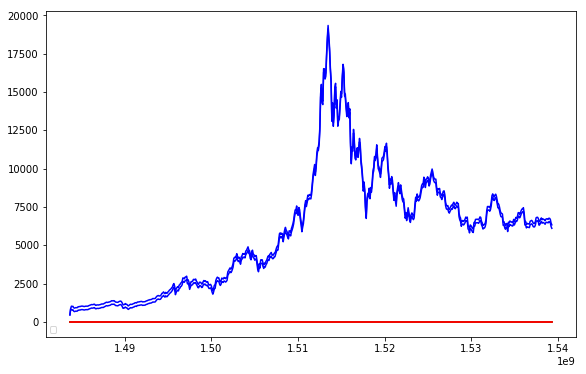

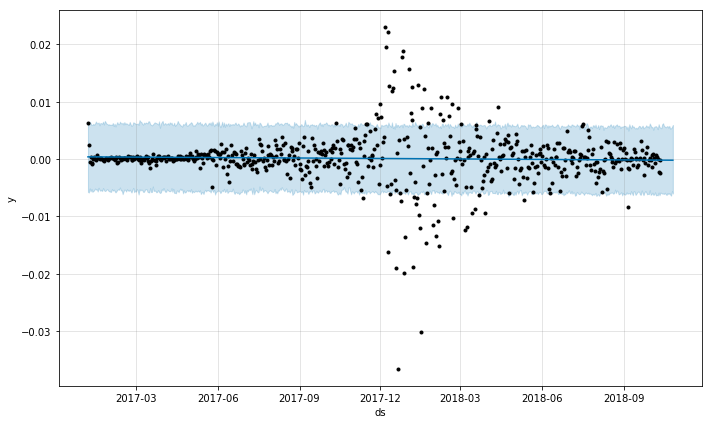

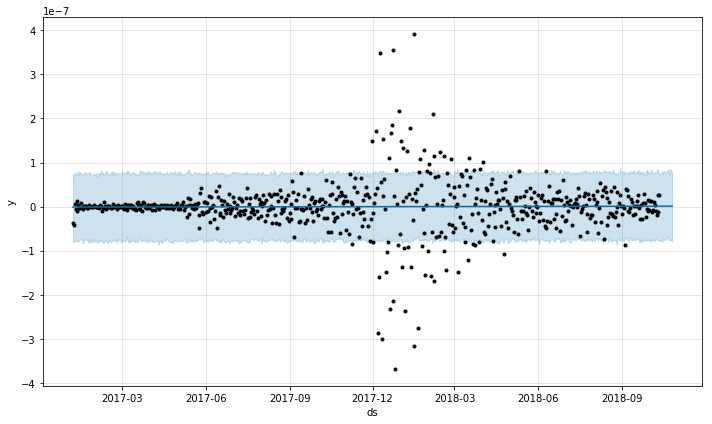

In [28]:
run(df)
p_df = df[['ds', 'velocity', 'acceleration']].copy()

p_df['y'] = p_df['velocity']
m = Prophet(seasonality_mode='multiplicative')
m.fit(p_df)
future = m.make_future_dataframe(periods=14)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

p_df['y'] = p_df['acceleration']
m = Prophet(seasonality_mode='multiplicative')
m.fit(p_df)
future = m.make_future_dataframe(periods=14)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

## Monthly Subsets

(2017, 1)
count    26.000000
mean      0.000367
std       0.001413
min      -0.000959
25%      -0.000068
50%       0.000080
75%       0.000224
max       0.006648
Name: velocity, dtype: float64
count    2.600000e+01
mean    -2.658979e-09
std      1.289612e-08
min     -4.428865e-08
25%     -3.012060e-09
50%     -3.846191e-10
75%      3.218082e-09
max      1.294022e-08
Name: acceleration, dtype: float64


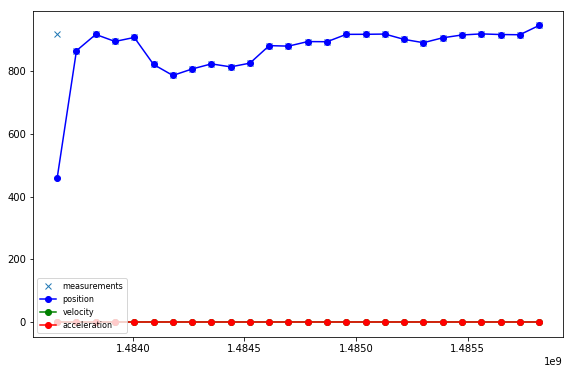

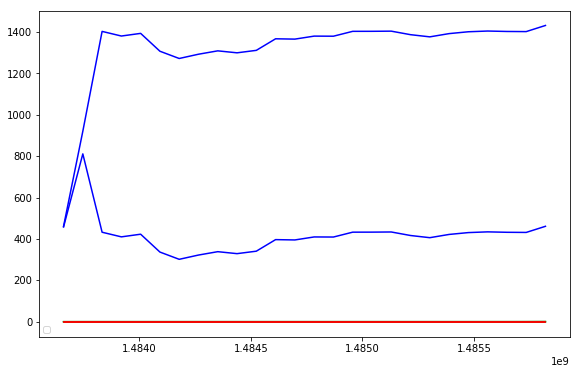

(2017, 2)
count    28.000000
mean      0.000464
std       0.001741
min      -0.000628
25%      -0.000095
50%       0.000165
75%       0.000290
max       0.009037
Name: velocity, dtype: float64
count    2.800000e+01
mean    -3.970774e-09
std      1.614198e-08
min     -6.951892e-08
25%     -2.669888e-09
50%     -5.486335e-10
75%      2.533659e-09
max      1.077536e-08
Name: acceleration, dtype: float64


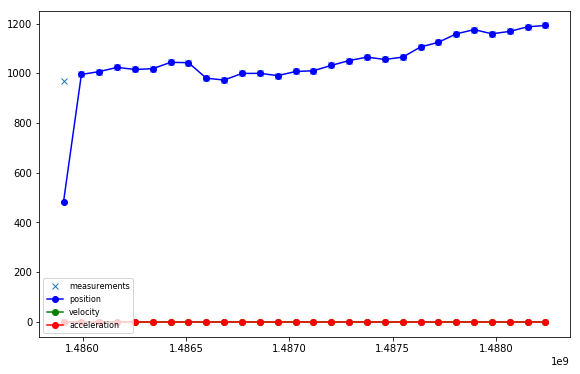

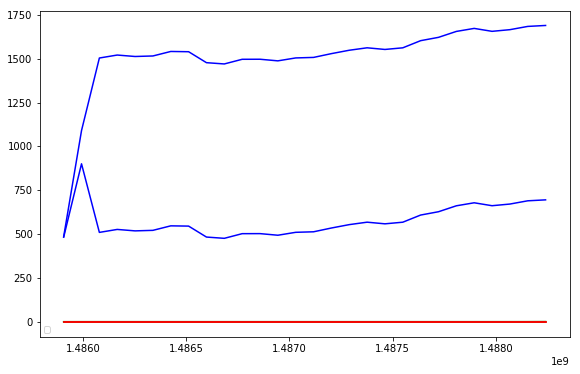

(2017, 3)
count    31.000000
mean      0.000362
std       0.002121
min      -0.001621
25%      -0.000263
50%      -0.000070
75%       0.000318
max       0.011096
Name: velocity, dtype: float64
count    3.100000e+01
mean    -4.065263e-09
std      1.914936e-08
min     -8.246652e-08
25%     -5.774098e-09
50%      7.492724e-10
75%      4.017335e-09
max      1.118022e-08
Name: acceleration, dtype: float64


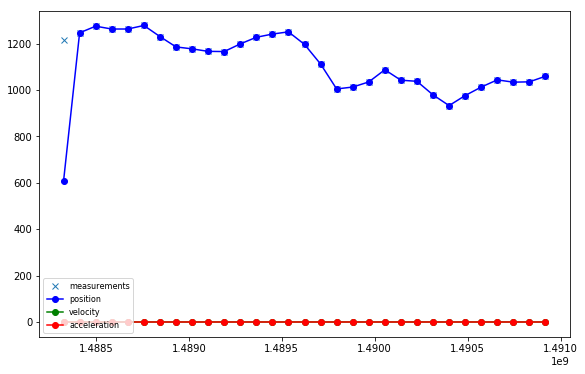

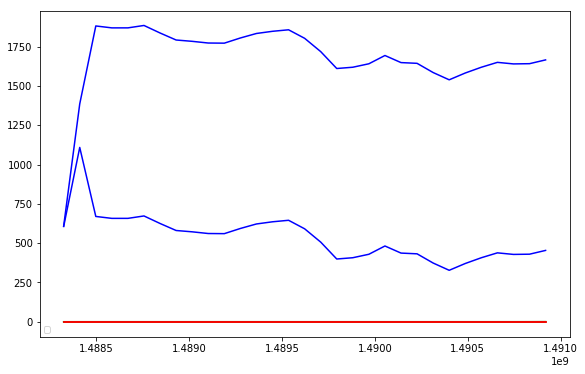

(2017, 4)
count    30.000000
mean      0.000510
std       0.001782
min      -0.000365
25%      -0.000028
50%       0.000079
75%       0.000314
max       0.009577
Name: velocity, dtype: float64
count    3.000000e+01
mean    -3.938964e-09
std      1.579049e-08
min     -7.022274e-08
25%     -2.884431e-09
50%     -1.744176e-10
75%      2.558049e-09
max      6.343170e-09
Name: acceleration, dtype: float64


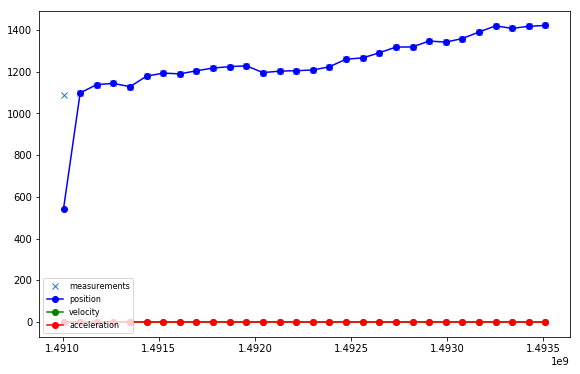

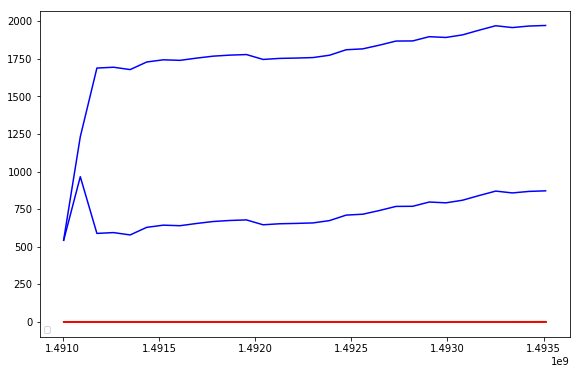

(2017, 5)
count    31.000000
mean      0.000742
std       0.002859
min      -0.004990
25%      -0.000015
50%       0.000367
75%       0.000886
max       0.014309
Name: velocity, dtype: float64
count    3.100000e+01
mean    -6.626246e-09
std      2.931146e-08
min     -1.100105e-07
25%     -1.885543e-08
50%     -5.436473e-10
75%      6.120415e-09
max      4.732995e-08
Name: acceleration, dtype: float64


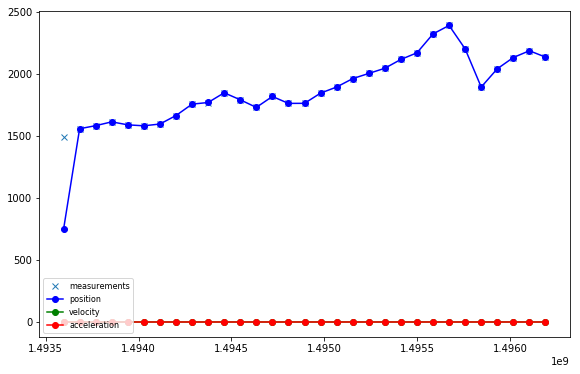

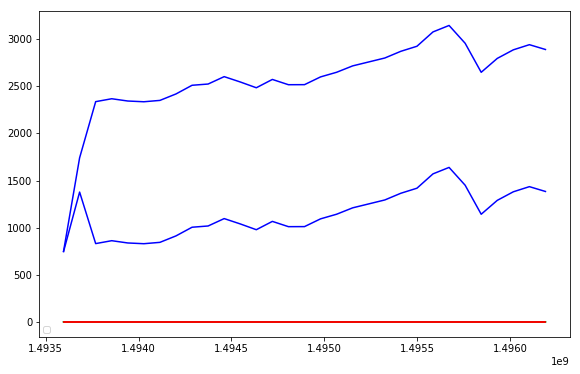

(2017, 6)
count    30.000000
mean      0.000862
std       0.004060
min      -0.004114
25%      -0.000939
50%       0.000222
75%       0.001318
max       0.020144
Name: velocity, dtype: float64
count    3.000000e+01
mean    -8.047112e-09
std      3.930469e-08
min     -1.448722e-07
25%     -1.832357e-08
50%      1.235221e-09
75%      1.498996e-08
max      4.982696e-08
Name: acceleration, dtype: float64


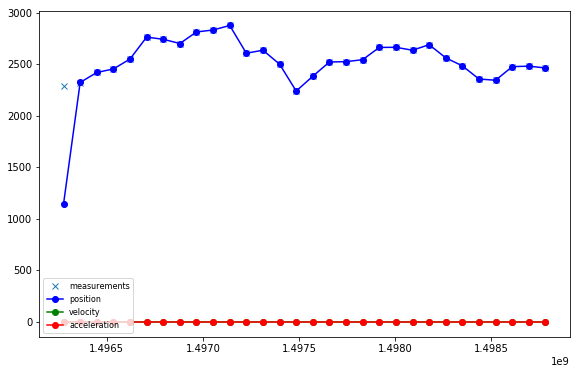

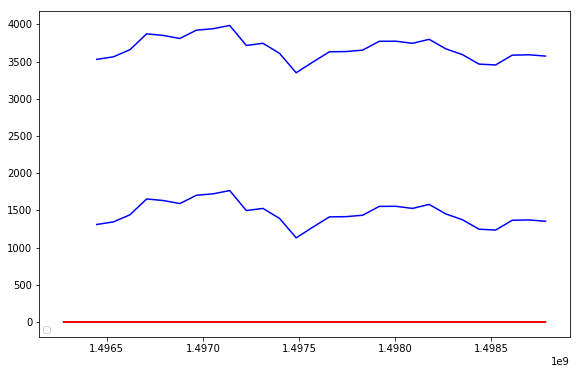

(2017, 7)
count    31.000000
mean      0.000984
std       0.004000
min      -0.002391
25%      -0.000670
50%      -0.000061
75%       0.001204
max       0.020345
Name: velocity, dtype: float64
count    3.100000e+01
mean    -6.575139e-09
std      3.624070e-08
min     -1.452133e-07
25%     -1.664756e-08
50%     -6.946612e-09
75%      1.826644e-08
max      4.607965e-08
Name: acceleration, dtype: float64


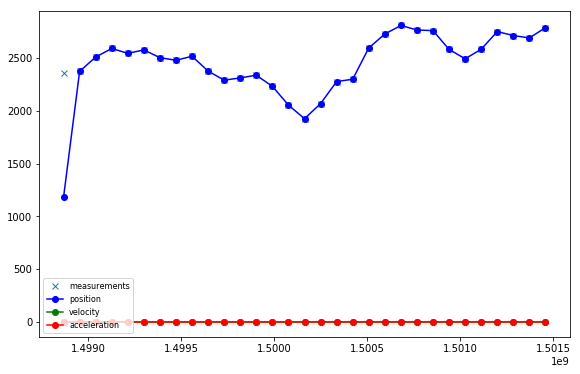

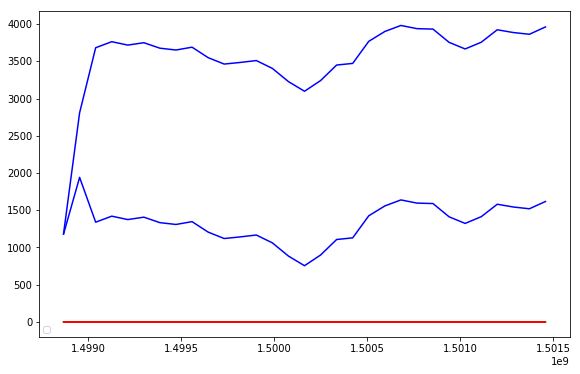

(2017, 8)
count    31.000000
mean      0.001681
std       0.004428
min      -0.003425
25%      -0.000216
50%       0.000857
75%       0.002120
max       0.023136
Name: velocity, dtype: float64
count    3.100000e+01
mean    -7.651618e-09
std      4.631836e-08
min     -1.724733e-07
25%     -2.069438e-08
50%     -2.460272e-09
75%      1.933186e-08
max      6.151021e-08
Name: acceleration, dtype: float64


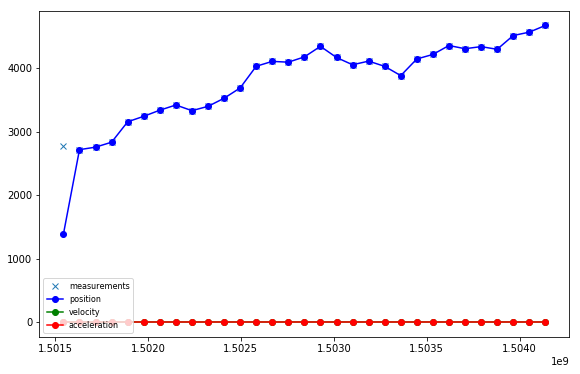

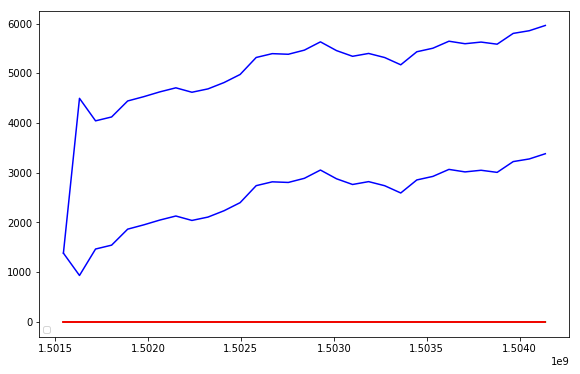

(2017, 9)
count    30.000000
mean      0.001502
std       0.007696
min      -0.004994
25%      -0.001346
50%       0.000051
75%       0.002166
max       0.039016
Name: velocity, dtype: float64
count    3.000000e+01
mean    -1.251348e-08
std      7.734816e-08
min     -3.038687e-07
25%     -2.357479e-08
50%     -3.511112e-09
75%      2.617203e-08
max      8.220578e-08
Name: acceleration, dtype: float64


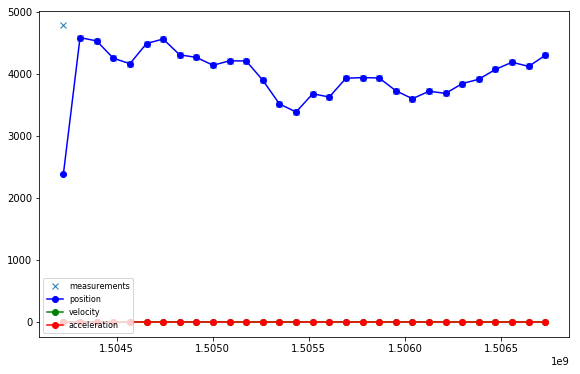

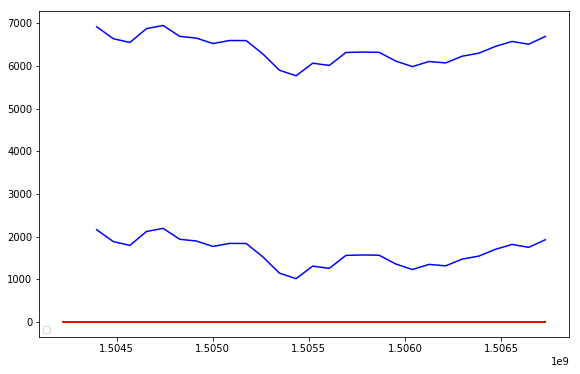

(2017, 10)
count    31.000000
mean      0.002303
std       0.007664
min      -0.004519
25%      -0.000809
50%       0.001516
75%       0.002560
max       0.041014
Name: velocity, dtype: float64
count    3.100000e+01
mean    -1.460817e-08
std      7.930720e-08
min     -3.359257e-07
25%     -2.781434e-08
50%      4.735745e-09
75%      2.687992e-08
max      6.361905e-08
Name: acceleration, dtype: float64


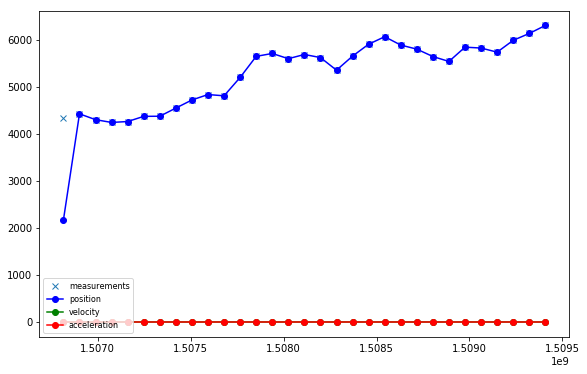

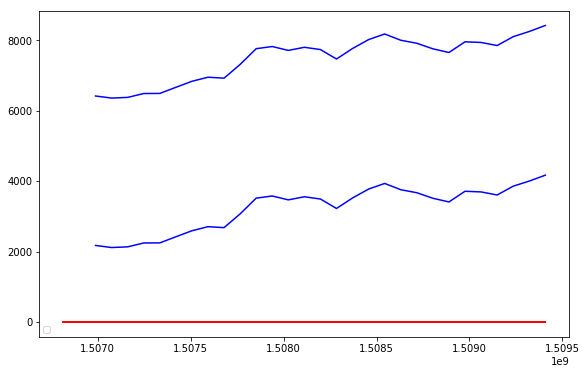

(2017, 11)
count    30.000000
mean      0.003379
std       0.012356
min      -0.012055
25%      -0.001242
50%       0.001164
75%       0.004815
max       0.062122
Name: velocity, dtype: float64
count    3.000000e+01
mean    -3.422980e-08
std      1.158347e-07
min     -4.386519e-07
25%     -4.425404e-08
50%     -1.009589e-08
75%      2.743518e-08
max      8.855331e-08
Name: acceleration, dtype: float64


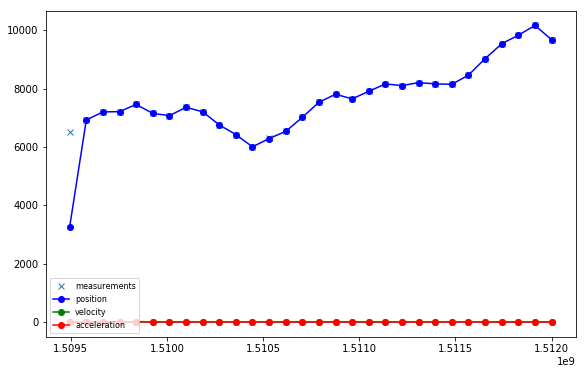

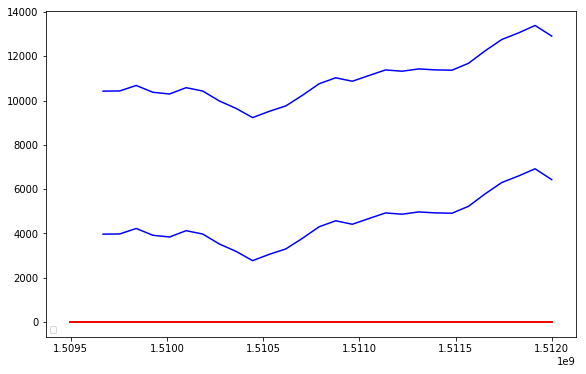

(2017, 12)
count    31.000000
mean      0.005184
std       0.023346
min      -0.037141
25%      -0.006142
50%       0.001659
75%       0.017161
max       0.100288
Name: velocity, dtype: float64
count    3.100000e+01
mean    -1.890170e-08
std      2.699907e-07
min     -7.261675e-07
25%     -1.709436e-07
50%      2.544872e-08
75%      1.420764e-07
max      4.155765e-07
Name: acceleration, dtype: float64


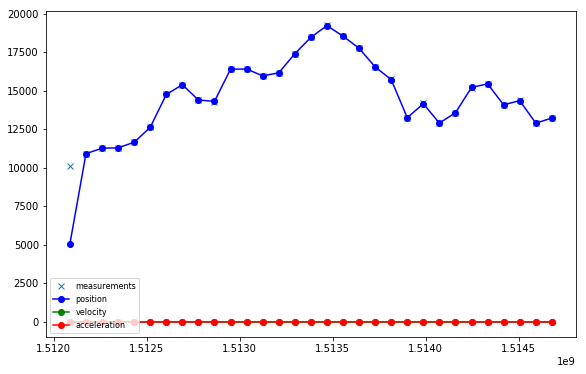

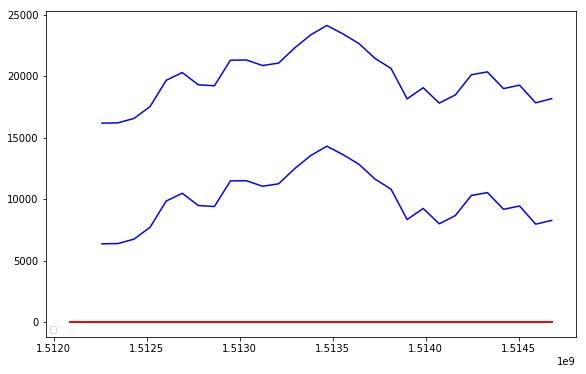

(2018, 1)
count    31.000000
mean      0.003333
std       0.025601
min      -0.030723
25%      -0.008494
50%      -0.000337
75%       0.007603
max       0.122597
Name: velocity, dtype: float64
count    3.100000e+01
mean    -4.445954e-08
std      2.480135e-07
min     -8.094534e-07
25%     -9.529850e-08
50%      1.672583e-08
75%      1.139235e-07
max      4.061050e-07
Name: acceleration, dtype: float64


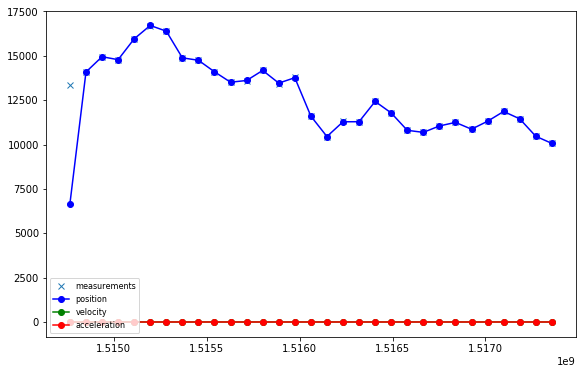

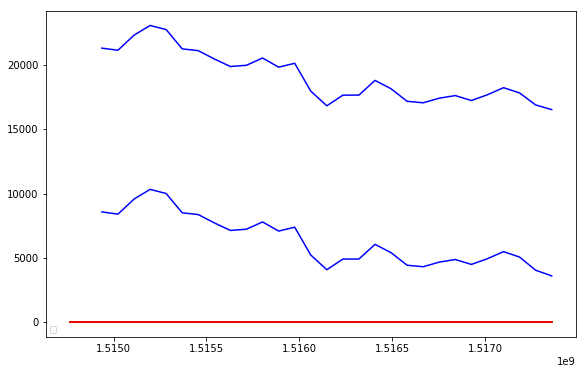

(2018, 2)
count    28.000000
mean      0.003637
std       0.014487
min      -0.015969
25%      -0.003552
50%       0.001421
75%       0.007743
max       0.066122
Name: velocity, dtype: float64
count    2.800000e+01
mean    -3.335531e-08
std      1.471218e-07
min     -4.550837e-07
25%     -9.000088e-08
50%     -3.613981e-08
75%      7.174073e-08
max      2.310013e-07
Name: acceleration, dtype: float64


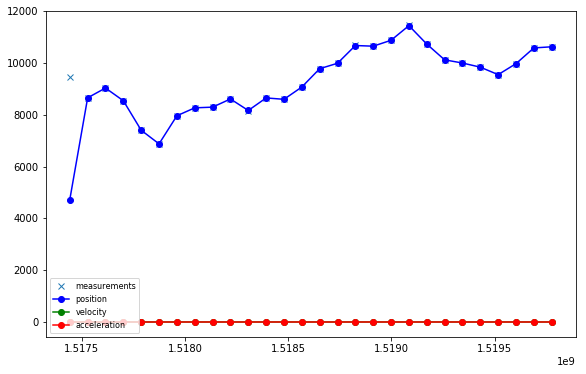

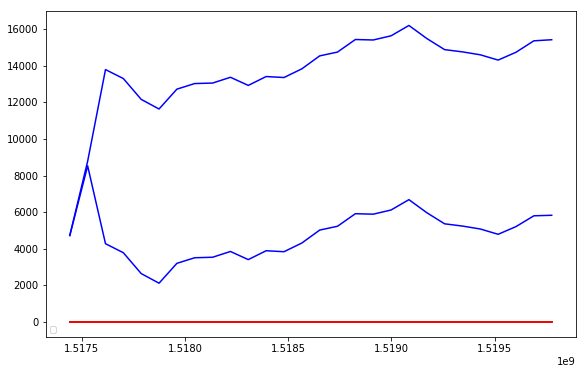

(2018, 3)
count    31.000000
mean      0.002330
std       0.018982
min      -0.012552
25%      -0.005254
50%       0.000548
75%       0.002895
max       0.096556
Name: velocity, dtype: float64
count    3.100000e+01
mean    -3.242864e-08
std      1.763209e-07
min     -6.954785e-07
25%     -6.267990e-08
50%      5.842070e-09
75%      7.303014e-08
max      1.230035e-07
Name: acceleration, dtype: float64


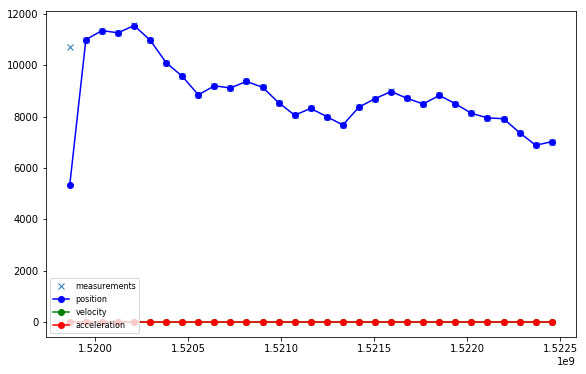

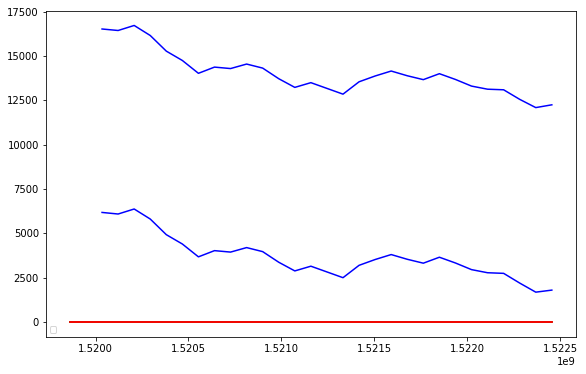

(2018, 4)
count    30.000000
mean      0.003326
std       0.011796
min      -0.006146
25%      -0.001349
50%       0.000878
75%       0.003244
max       0.060653
Name: velocity, dtype: float64
count    3.000000e+01
mean    -2.685387e-08
std      1.082513e-07
min     -4.137537e-07
25%     -4.222705e-08
50%      5.678260e-09
75%      3.256884e-08
max      6.710016e-08
Name: acceleration, dtype: float64


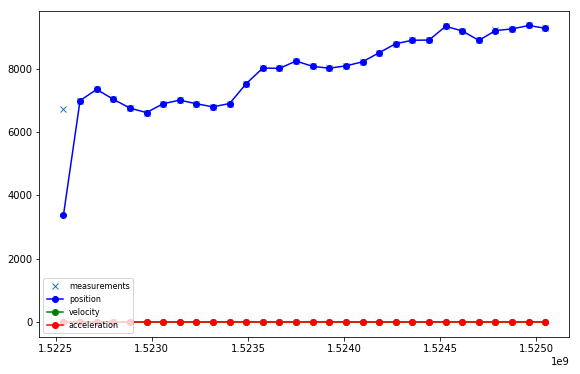

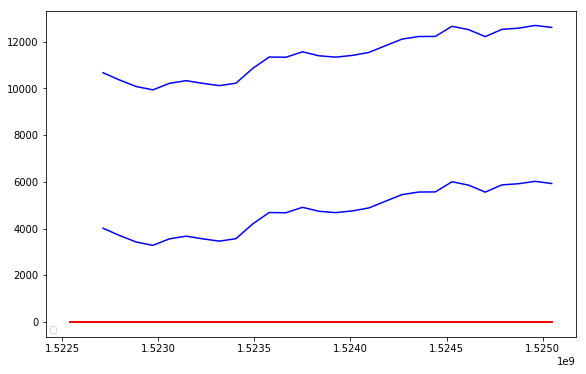

(2018, 5)
count    31.000000
mean      0.002473
std       0.015029
min      -0.007388
25%      -0.001834
50%      -0.000119
75%       0.001288
max       0.079204
Name: velocity, dtype: float64
count    3.100000e+01
mean    -3.016494e-08
std      1.311054e-07
min     -5.715813e-07
25%     -2.700983e-08
50%     -9.593419e-10
75%      2.249862e-08
max      9.070255e-08
Name: acceleration, dtype: float64


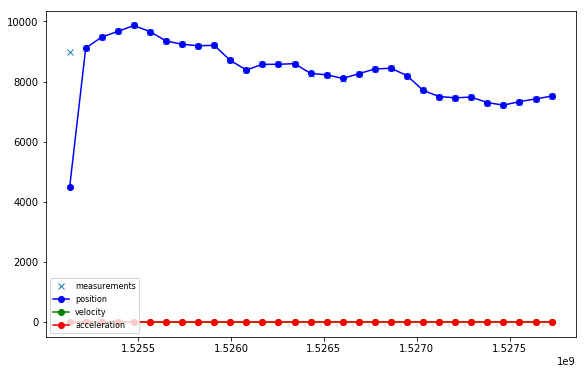

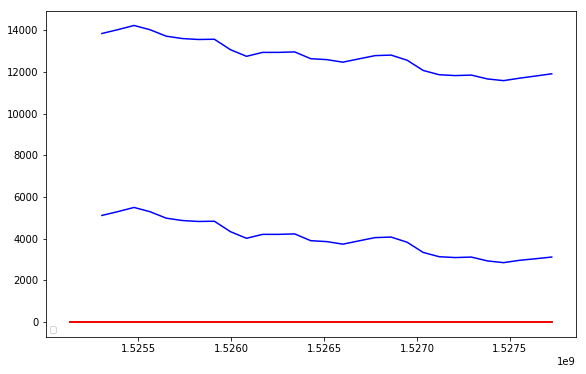

(2018, 6)
count    30.000000
mean      0.002354
std       0.013143
min      -0.006225
25%      -0.001659
50%      -0.000392
75%       0.001928
max       0.067877
Name: velocity, dtype: float64
count    3.000000e+01
mean    -2.147844e-08
std      1.235068e-07
min     -5.115070e-07
25%     -3.501752e-08
50%      9.828500e-09
75%      3.081958e-08
max      8.709585e-08
Name: acceleration, dtype: float64


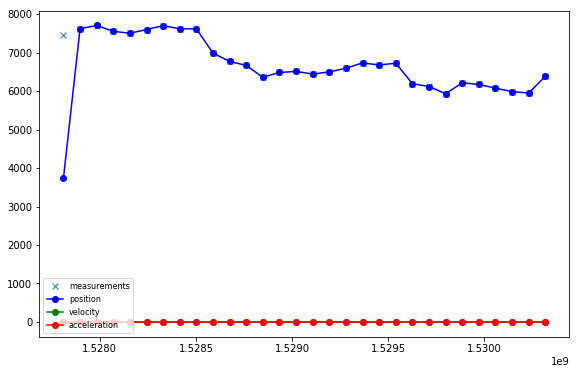

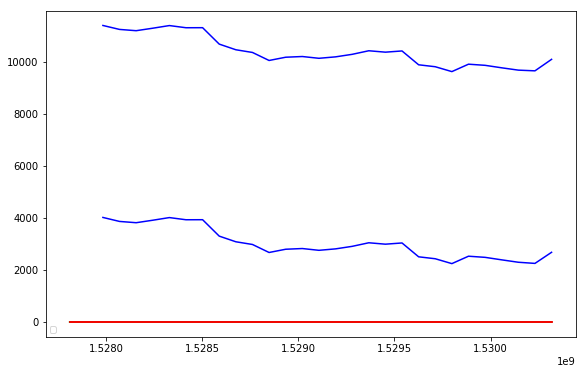

(2018, 7)
count    31.000000
mean      0.002713
std       0.011202
min      -0.003448
25%      -0.001085
50%       0.000369
75%       0.001506
max       0.060271
Name: velocity, dtype: float64
count    3.100000e+01
mean    -2.503898e-08
std      1.046095e-07
min     -4.697673e-07
25%     -2.202938e-08
50%      1.460567e-09
75%      1.612157e-08
max      7.923042e-08
Name: acceleration, dtype: float64


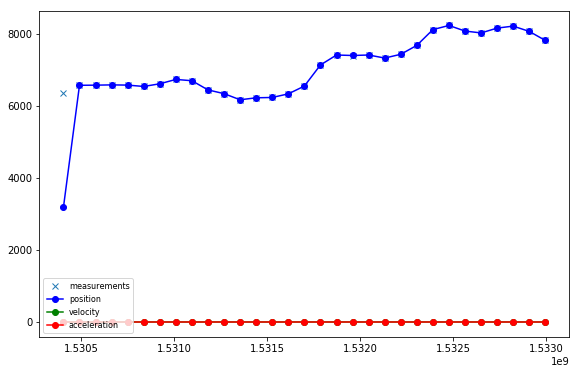

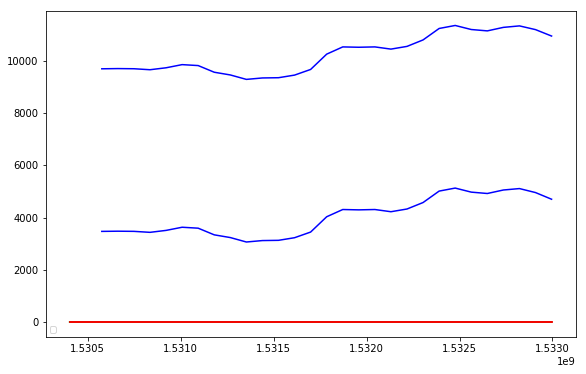

(2018, 8)
count    31.000000
mean      0.002406
std       0.012740
min      -0.006700
25%      -0.001431
50%       0.000017
75%       0.002432
max       0.068275
Name: velocity, dtype: float64
count    3.100000e+01
mean    -2.434993e-08
std      1.252925e-07
min     -5.471028e-07
25%     -2.553309e-08
50%     -1.433288e-09
75%      3.877920e-08
max      8.797049e-08
Name: acceleration, dtype: float64


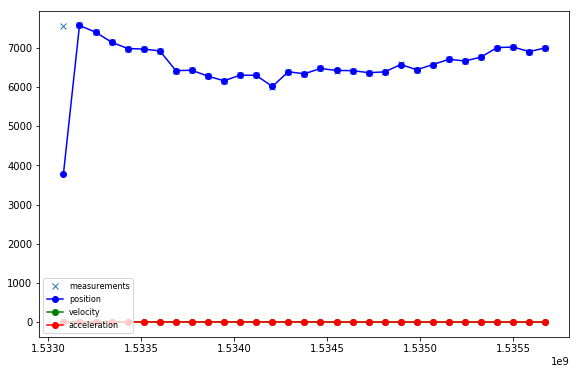

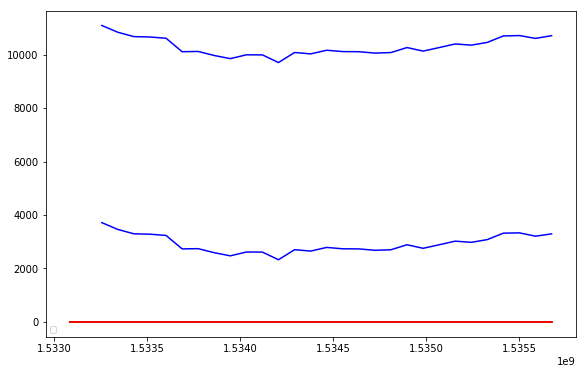

(2018, 9)
count    30.000000
mean      0.002346
std       0.012360
min      -0.008791
25%      -0.000988
50%       0.000061
75%       0.001230
max       0.065307
Name: velocity, dtype: float64
count    3.000000e+01
mean    -2.417548e-08
std      1.152524e-07
min     -5.095578e-07
25%     -1.674524e-08
50%      2.084467e-09
75%      2.442368e-08
max      7.817562e-08
Name: acceleration, dtype: float64


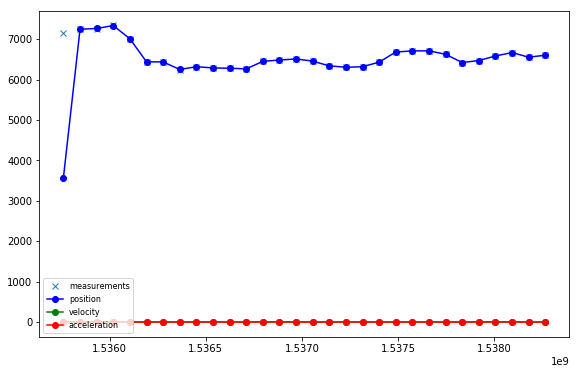

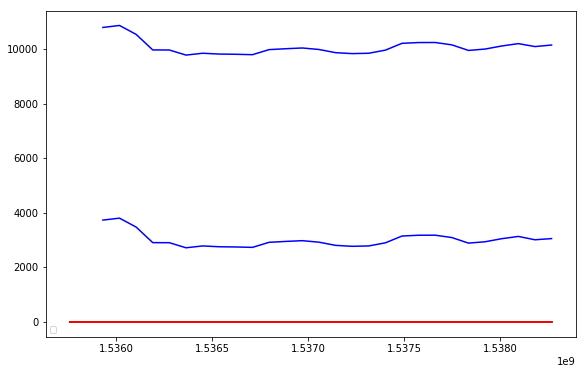

(2018, 10)
count    12.000000
mean      0.005359
std       0.016878
min      -0.003379
25%      -0.001165
50%      -0.000101
75%       0.001086
max       0.057095
Name: velocity, dtype: float64
count    1.200000e+01
mean    -5.519111e-08
std      1.591091e-07
min     -4.033579e-07
25%     -2.761877e-08
50%     -6.333278e-09
75%      1.600655e-08
max      1.176980e-07
Name: acceleration, dtype: float64


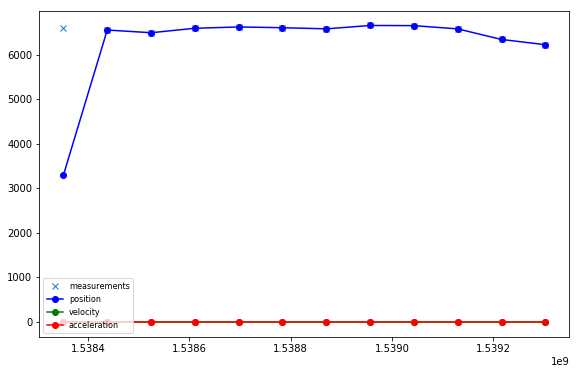

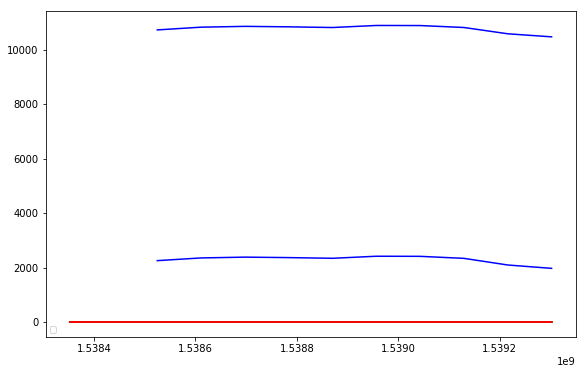

In [29]:

#monthly
d = OrderedDict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items():
    print(i)
    run(df_month)

In [8]:
x_mean,x_std,x_covar=fitKCA(df.date.values,df.y.values,1)

In [9]:
# Mean Acceleration

In [10]:
print(x_mean[0,2])

9.272110949960804e-08


In [11]:
# Std Acceleration

In [12]:
print(x_std[0,2])

2.200859612902876e-05


In [13]:
# Mean Velocity/Inertia

In [14]:
print(x_mean[0,1])

0.0006986698450682496


In [15]:
# Std Velocity/Inertia

In [16]:
print(x_std[0,1])

0.9492973229863927


## Figure 1: KCA estimated mean states

Text(0.5,1,'Measurements: Weighted Average Prices')

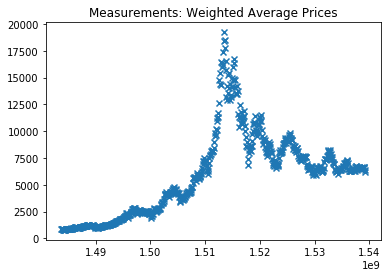

In [17]:
#measurements
plt.scatter(df.date, df.weightedAverage, marker='x')
plt.title('Measurements: Weighted Average Prices')

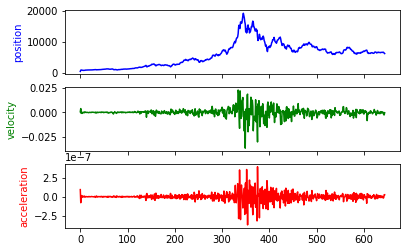

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=False, sharex='all')
ax1.plot(x_mean[:,0],color='b')
ax1.set_ylabel('position',color='b')
ax2.plot(x_mean[:,1],color='g')
ax2.set_ylabel('velocity',color='g')
ax3.plot(x_mean[:,2],color='r')
ax3.set_ylabel('acceleration',color='r')
plt.show()

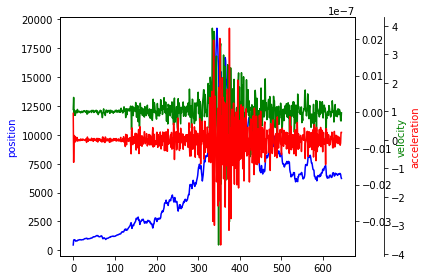

In [19]:
# To make things reproducible...
np.random.seed(1977)

#fig, ax = plt.subplots()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
fig.subplots_adjust(right=0.75)
ax3.spines['right'].set_position(('axes', 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)

#position
ax1.set_ylabel('position',color='b')
ax1.plot(x_mean[:,0],color='b')
#velocity
ax2.set_ylabel('velocity',color='g')
ax2.plot(x_mean[:,1],color='g')
#acceleration
ax3.set_ylabel('acceleration',color='r')
ax3.plot(x_mean[:,2],color='r')

fig.tight_layout()
plt.show()

## Figure 2 (shows that FFT extracts a signal very similar to the first state component extracted by KCA) 

In [20]:
# Not sure how to display this better...zooming in still doesn't show detail as in the paper

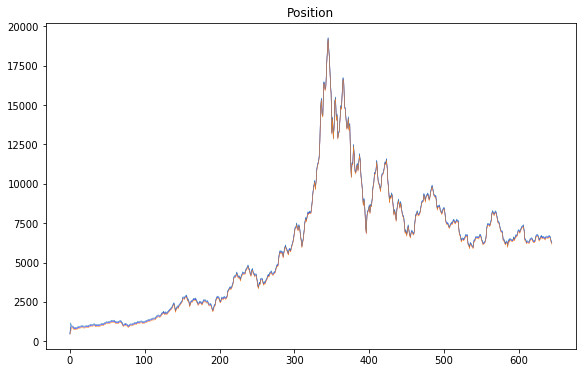

In [21]:
#mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [9.5,6] #width,height
#position
upper_error_bars = x_mean[:,0] + x_std[:,0]
lower_error_bars = x_mean[:,0] - x_std[:,0]
plt.plot(x_mean[:,0],color='blue',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)
plt.title('Position')
plt.show()

Text(0.5,1,'Velocity')

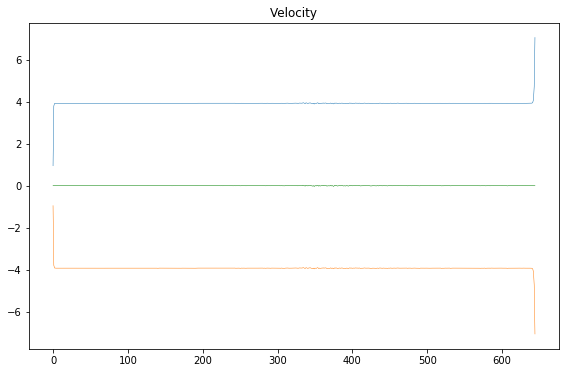

In [22]:
#velocity

upper_error_bars = x_mean[:,1] + x_std[:,1]
lower_error_bars = x_mean[:,1] - x_std[:,1]

plt.plot(x_mean[:,1],color='green',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Velocity')

Text(0.5,1,'Acceleration')

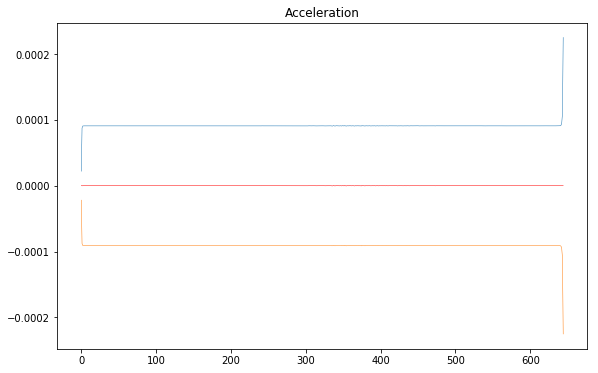

In [23]:
#acceleration

upper_error_bars = x_mean[:,2] + x_std[:,2]
lower_error_bars = x_mean[:,2] - x_std[:,2]

plt.plot(x_mean[:,2],color='red',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Acceleration')

## Estimated Position vs Price

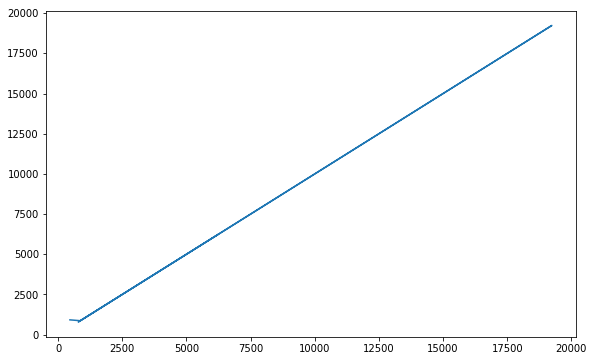

In [24]:
plt.plot(x_mean[:,0],df.weightedAverage)
#plt.plot(x_mean[:,0], color='b', linewidth=.45)
#plt.plot(df.weightedAverage, color='y',linewidth=.45)

In [25]:
# This linear relationship indicates that the estimated position and price values were practically equal 
# after the beginning period.